## Time Series Analysis and Forecasting of opening price of a stock

#### Time series analysis and forecasting help unveil hidden patterns in stock prices, like trends and seasonality. 📈📉
#### By analyzing past data, we can predict future prices, make informed investment decisions, and potentially maximize profits. 💰🧠

#### Importing libraries

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # just to ensure that pd DateTime objects are not needed to be type-casted to matplotlib types

# Time Series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

### ADF test and checking for stationarity.

Stationarity means the data's statistical properties (like mean, variance) are stable over time. Imagine a stock price bouncing around randomly - that's non-stationary. A price with clear trends or seasonality is stationary.

<font color=#FF0000>Why is it important?</font>

**Meaningful forecasts**: Non-stationary data throws off forecasting models. They'll chase trends and false signals, leading to inaccurate predictions.

**Valid statistical tests**: Many analysis methods assume stationarity. Applying them to non-stationary data gives misleading results.

#### The ADF test:

It checks for a "unit root" - a hidden trend that makes the data non-stationary.
If the test rejects the "unit root" hypothesis, we have a good chance of stationarity.

Stationarity matters:

It ensures our forecasts are based on real patterns, not just random noise.
It allows us to apply valid statistical tests and interpret results confidently.

In [2]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

### ETL (Extract Transform Load)

It ensures clean, consistent data allowing analysis models to navigate and extract meaningful patterns and more accurate forecasting.

In [3]:
#read data
tatasteel_df = pd.read_csv('TATASTEEL.NS.csv', index_col=False)


#looking at the dataset
tatasteel_df.head()

Date        Open        High         Low       Close   Adj Close    Volume
0  2022-12-01  108.699997  111.300003  108.000000  110.750000  107.249557  91702642
1  2022-12-02  110.800003  112.500000  110.150002  112.000000  108.460052  70541914
2  2022-12-05  113.300003  116.099998  112.650002  115.849998  112.188362  96441799
3  2022-12-06  115.349998  115.349998  112.250000  112.949997  109.380020  50581245
4  2022-12-07  113.400002  113.500000  110.849998  111.199997  107.685333  39494279

In [5]:
#Converting month name to number but for this to work the Date column should not be the index column
tatasteel_df['Date'] = pd.DatetimeIndex(tatasteel_df['Date']).date

In [6]:
tatasteel_df.head()

Date        Open        High         Low       Close   Adj Close    Volume
0  2022-12-01  108.699997  111.300003  108.000000  110.750000  107.249557  91702642
1  2022-12-02  110.800003  112.500000  110.150002  112.000000  108.460052  70541914
2  2022-12-05  113.300003  116.099998  112.650002  115.849998  112.188362  96441799
3  2022-12-06  115.349998  115.349998  112.250000  112.949997  109.380020  50581245
4  2022-12-07  113.400002  113.500000  110.849998  111.199997  107.685333  39494279

In [7]:
tatasteel_df.head(-5)

Date        Open        High         Low       Close   Adj Close    Volume
0    2022-12-01  108.699997  111.300003  108.000000  110.750000  107.249557  91702642
1    2022-12-02  110.800003  112.500000  110.150002  112.000000  108.460052  70541914
2    2022-12-05  113.300003  116.099998  112.650002  115.849998  112.188362  96441799
3    2022-12-06  115.349998  115.349998  112.250000  112.949997  109.380020  50581245
4    2022-12-07  113.400002  113.500000  110.849998  111.199997  107.685333  39494279
..          ...         ...         ...         ...         ...         ...       ...
237  2023-11-16  124.000000  125.250000  123.000000  124.699997  124.699997  30836413
238  2023-11-17  124.699997  125.750000  124.300003  125.199997  125.199997  23319439
239  2023-11-20  125.050003  125.650002  124.050003  124.349998  124.349998  18780290
240  2023-11-21  125.050003  126.400002  124.949997  126.250000  126.250000  29643312
241  2023-11-22  126.400002  126.900002  125.500000  126.099998  126.099998  19588063

[242 rows x 7 columns]

In [18]:
tatasteel_df2 = tatasteel_df.iloc[:, [0,1]]

In [19]:
tatasteel_df2['Date'] = pd.to_datetime(tatasteel_df2['Date'], format='%Y-%m-%d')

In [20]:
tatasteel_df2.head()

Date        Open
0 2022-12-01  108.699997
1 2022-12-02  110.800003
2 2022-12-05  113.300003
3 2022-12-06  115.349998
4 2022-12-07  113.400002

In [21]:
tatasteel_df2.head(-5)

Date        Open
0   2022-12-01  108.699997
1   2022-12-02  110.800003
2   2022-12-05  113.300003
3   2022-12-06  115.349998
4   2022-12-07  113.400002
..         ...         ...
237 2023-11-16  124.000000
238 2023-11-17  124.699997
239 2023-11-20  125.050003
240 2023-11-21  125.050003
241 2023-11-22  126.400002

[242 rows x 2 columns]

<AxesSubplot: title={'center': 'Open price'}, xlabel='Date'>

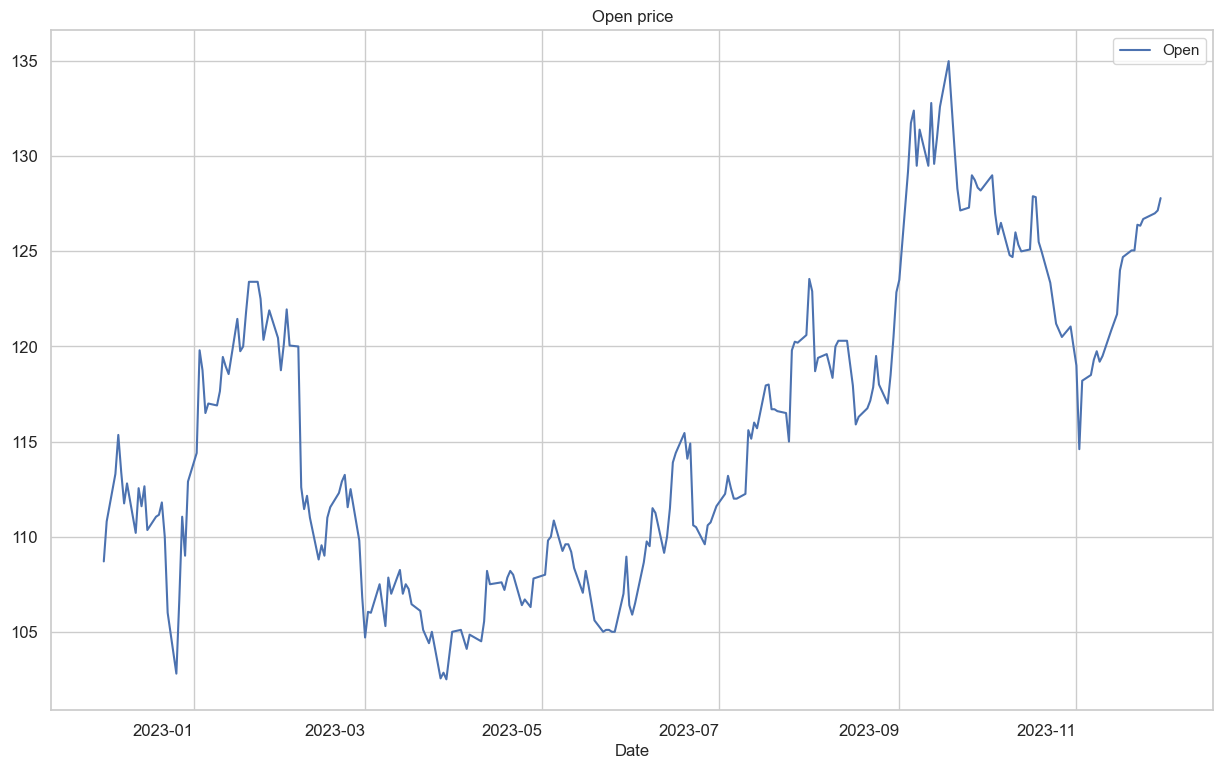

In [22]:

#infer the frequency of the data
#tatasteel_df = tatasteel_df.asfreq(pd.infer_freq(tatasteel_df.index))

# #transform
# start_date = datetime(2021-08-27)
# end_date = datetime(2022-08-19)
# lim_tatasteel_df = tatasteel_df[start_date:end_date] #limited range

# #plot
# plt.figure(figsize=(14,4))
# plt.plot(lim_tatasteel_df)
# plt.title('opening price', fontsize=20)
# plt.ylabel('Sales', fontsize=16)

# plt.figure(figsize=(60,40))
# plt.grid(True)
# plt.xlabel('Date')
# plt.ylabel('Open Prices')
# tatasteel_df2[['Date', 'Open Price']].plot()
# plt.title('Tatasteel opening price')
# plt.show()

tatasteel_df2 = tatasteel_df2.set_index('Date')
tatasteel_df2.plot(rot=0, title='Open price', figsize=(15,10), fontsize=12)

### Stationarity check

To check stability of data for reliable prediction.  

In [23]:
tatasteel_df2.head()

Open
Date                  
2022-12-01  108.699997
2022-12-02  110.800003
2022-12-05  113.300003
2022-12-06  115.349998
2022-12-07  113.400002

In [24]:
check_stationarity(tatasteel_df2)

The series is NOT stationary


### STL Decomposition

It breaks down trends, seasonality, and noise, giving you a clear picture of what drives the data. 

In [25]:
# plt.rc('figure',figsize=(14,8))
# plt.rc('font',size=15)
# # tatasteel_df2['Date'] = pd.to_numeric(pd.to_datetime(tatasteel_df2['Date']))
# # result = seasonal_decompose(tatasteel_df2,model='additive')
# # fig = result.plot()

# import statsmodels as sm
# import statsmodels.api as sm
# decomposition = sm.tsa.seasonal_decompose(tatasteel_df2, model = 'additive', period = 1)
# fig = decomposition.plot()
# # matplotlib.rcParams['figure.figsize'] = [9.0,5.0]

from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(df, column_name):
    """
    A function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend = 'freq', period = 10)
    result_add = seasonal_decompose(df[column_name], model = 'additive', extrapolate_trend='freq', period = 10)

    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return result_mul, result_add

### Multiplicative Additive Decompose

#### Multiplicative decomposition used to see:-

**Seasonal variations remain relatively constant**: If the seasonal fluctuations in price are similar throughout the data, like a consistent dip in June, additive decomposition might be more accurate.

**Trends are linear or slightly non-linear**: If the overall price trend increases or decreases at a steady pace, or has slight deviations, additive decomposition can capture this trend effectively.

**Data values are relatively small**: For stocks with lower price ranges, additive decomposition can provide clearer insights into the magnitude of seasonal variations and noise.

#### Additive decomposition used to see:-

**Seasonal variations change with price level**: If high prices have larger seasonal fluctuations than low prices, or vice versa, multiplicative decomposition accounts for this scaling effect.

**Trends are exponential or highly non-linear**: For stocks with rapid growth or significant price jumps, multiplicative decomposition can better represent the changing impact of seasonality.

**Data values have a wide range:** When dealing with stocks that fluctuate greatly, multiplicative decomposition helps understand the proportional changes due to seasonality and noise.

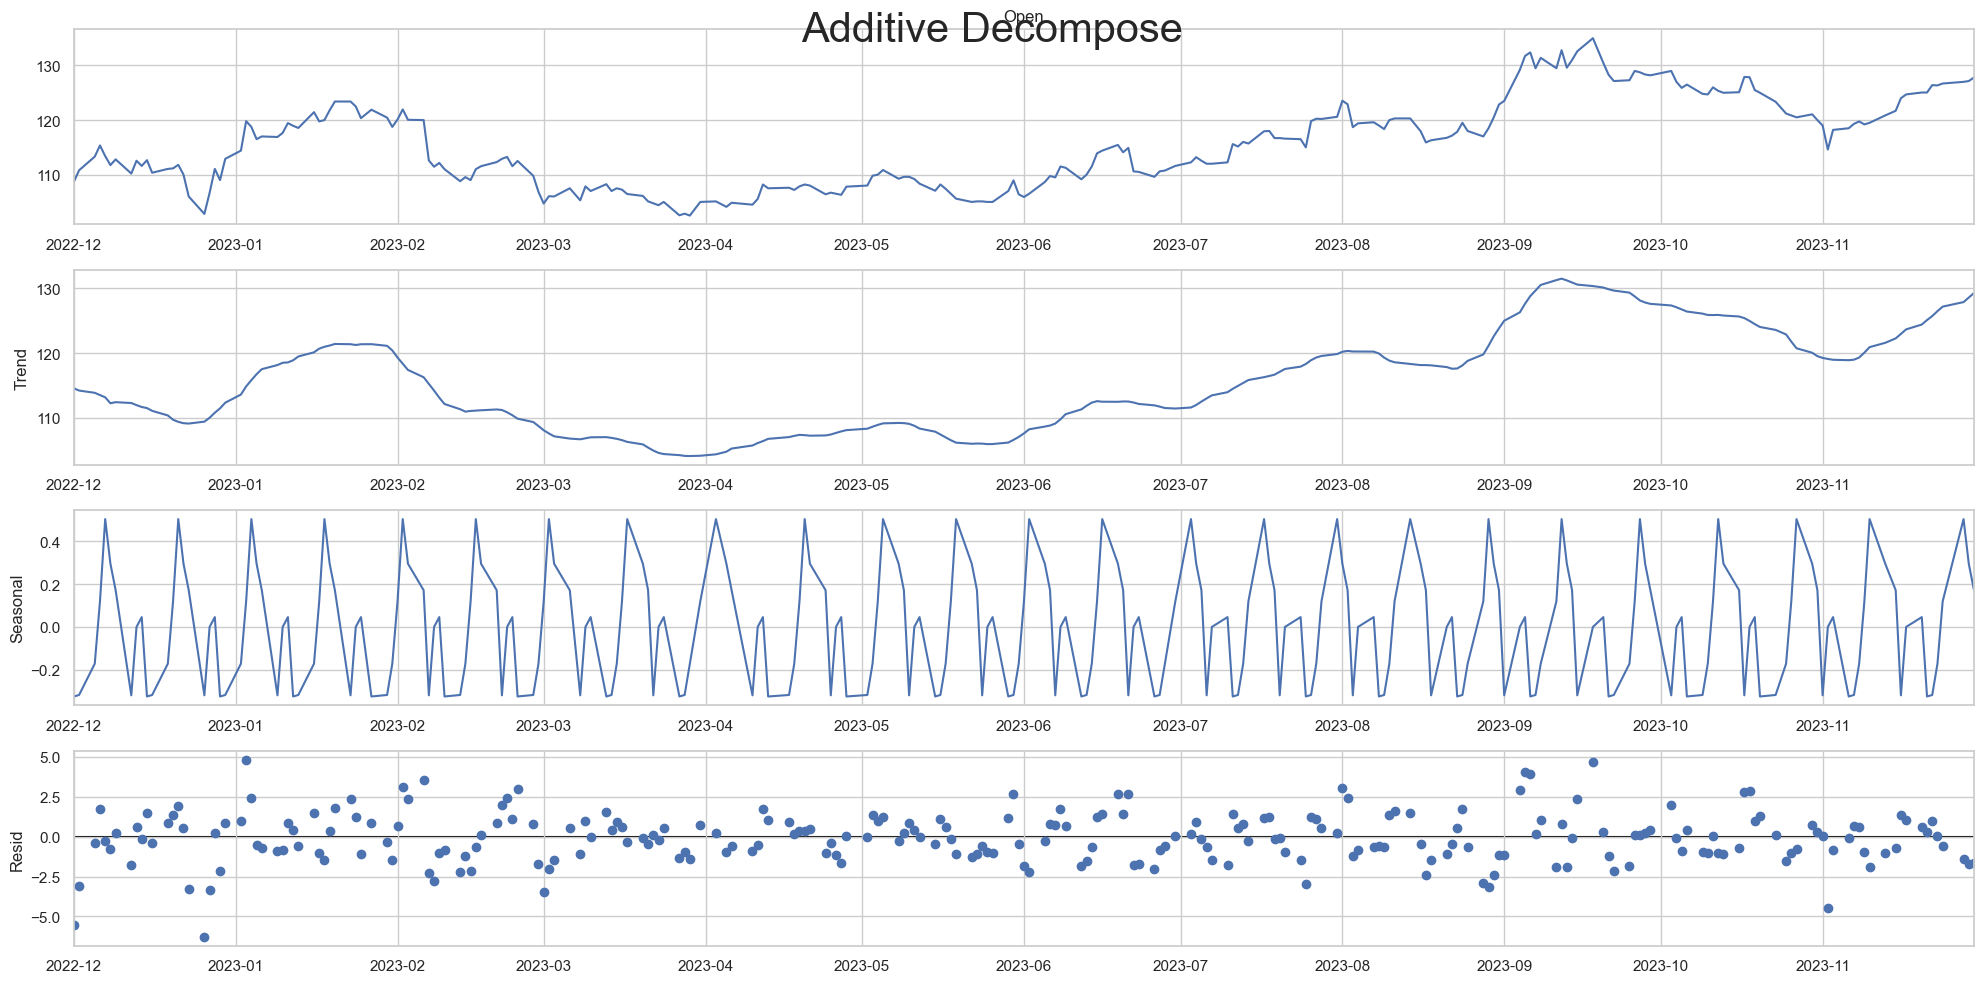

In [26]:
result_mul, result_add = decompose(tatasteel_df2, 'Open')

In [28]:
plot_acf(tatasteel_df2['Open'], lags=50);

In [29]:
plot_pacf(tatasteel_df2['Open'], lags=31);

### Fitting ARIMA

In [30]:
arima = sm.tsa.arima.ARIMA(tatasteel_df2['Open'], order=(12,1,1))
predictions = arima.fit().predict()

In [36]:
plt.figure(figsize=(16,4))
plt.plot(tatasteel_df2.diff(), label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Open price of the share', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.legend()

### SARIMA

SARIMA, or Seasonal Autoregressive Integrated Moving Average, is a powerful statistical tool commonly used for time series forecasting. It excels in situations where data exhibits seasonality, meaning predictable patterns that repeat over fixed intervals (e.g., daily, weekly, yearly).

#### How it works:

**Autoregressive (AR)**: SARIMA leverages past data points to predict future values. It considers the influence of recent values (e.g., yesterday's price) on today's price.

**Integrated (I)**: This step ensures stationarity, making the data's statistical properties stable over time. Think of it as detrending the data to reveal underlying patterns.

**Moving Average (MA)**: SARIMA accounts for random fluctuations by incorporating past errors into the forecast. This helps smooth out noise and improve prediction accuracy.

**Seasonal (S)**: The magic ingredient! This component captures the repeating seasonal patterns in the data. It considers the influence of past values at the same seasonal interval (e.g., last week's price on this week's price).


In [32]:
sarima = SARIMAX(tatasteel_df2['Open'], 
                order=(1,1,1), 
                seasonal_order=(1,1,0,12))
predictions = sarima.fit().predict()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08842D+00    |proj g|=  1.09391D-01

At iterate    5    f=  2.06218D+00    |proj g|=  4.83646D-04

At iterate   10    f=  2.06208D+00    |proj g|=  8.37802D-03

At iterate   15    f=  2.06182D+00    |proj g|=  4.58465D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   1.773D-05   2.062D+00
  F =   2.0618160090495632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


### Plotting the open price predict using SARIMA

In [37]:
plt.figure(figsize=(16,4))
plt.plot(tatasteel_df2, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Open price of the share', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.legend()